## จับบบรรทัด

Lines detected: [(78, 111), (195, 221), (312, 345), (429, 455), (546, 579), (663, 689)]


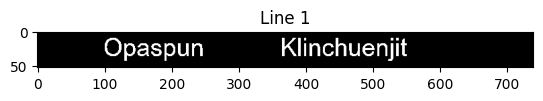

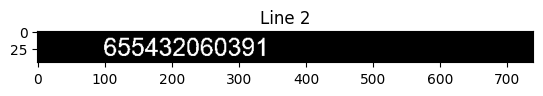

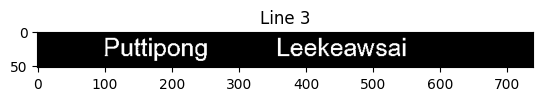

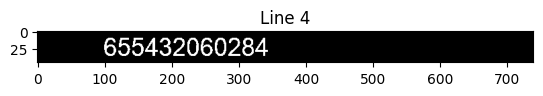

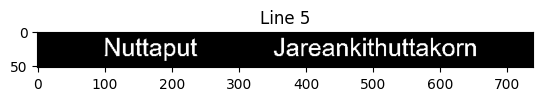

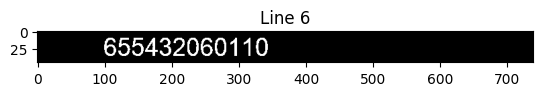

Saved lines to ..\data\output_images\output_lines


In [267]:
import cv2
from matplotlib import table
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

output_folder = Path("../data/output_images/output_lines")
output_folder.mkdir(exist_ok=True)

# โหลดภาพ
#image = cv2.imread("../data/test_images/transcript/Transcript.jpg")
#image = cv2.imread("../data/test_images/transcript/Transcript2.jpg")
image = cv2.imread("../data/test_images/word_images/word_9.jpg")
if image is None:
    raise FileNotFoundError("ไม่พบไฟล์ภาพ กรุณาตรวจสอบเส้นทางของไฟล์")

# แปลงเป็น Grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# การ Threshold แบบ Adaptive Gaussian
binary_image = cv2.adaptiveThreshold(
    gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 51,30
)

# สร้าง Kernel ขนาดเล็กสำหรับลบเส้นแนวนอน
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (40, 1))
horizontal_removed = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, horizontal_kernel)

# สร้าง Kernel ขนาดเล็กสำหรับลบเส้นแนวตั้ง
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 40))
vertical_removed = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, vertical_kernel)

# รวมเส้นแนวตั้งและแนวนอน
grid_lines = cv2.add(horizontal_removed, vertical_removed)

# ลบเส้นตารางออกจากภาพ
table_removed_image = cv2.subtract(binary_image, grid_lines)

# คำนวณ Histogram Projection
horizontal_projection = np.sum(table_removed_image, axis=1)  # รวมพิกเซลในแนวนอน

threshold_value = 10  # เพิ่มค่าให้เหมาะกับความหนาของตัวอักษร
line_indices = np.where(horizontal_projection > threshold_value)[0]

# แยกช่วงตำแหน่งแต่ละบรรทัด
lines = []
start_idx = None

for i in range(len(line_indices) - 1):
    if start_idx is None:
        start_idx = line_indices[i]
    if line_indices[i+1] > line_indices[i] + 1:  # เจอช่วงว่างระหว่างบรรทัด
        end_idx = line_indices[i]
        lines.append((start_idx, end_idx))
        start_idx = None
if start_idx is not None:
    lines.append((start_idx, line_indices[-1]))

print("Lines detected:", lines)

# แยกบรรทัดและเพิ่ม Padding
line_images = []
padding = 10  # ระบุ Padding

for start, end in lines:
    padded_start = max(0, start - padding)
    padded_end = min(table_removed_image.shape[0], end + padding)
    line_img = table_removed_image[padded_start:padded_end, :]
    line_images.append(line_img)


for idx, line_img in enumerate(line_images):
    file_path = output_folder / f"line_{idx + 1}.png"
    cv2.imwrite(str(file_path), line_img)
    plt.figure()
    plt.imshow(line_img, cmap="gray")
    plt.title(f"Line {idx + 1}")
    plt.show()
print(f"Saved lines to {output_folder}")




## จับข้อความในบรรทัด

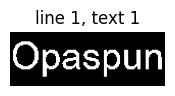

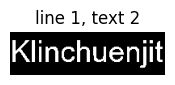

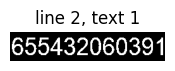

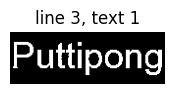

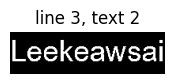

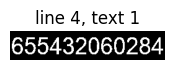

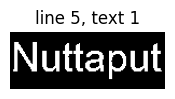

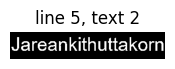

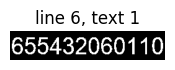

In [268]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def histogram_projection(images, distance):
    # คำนวณ Histogram Projection
    horizontal_projection = np.sum(images, axis=0)  # รวมพิกเซลในแนวนอน
    threshold_value = 1  # เพิ่มค่าให้เหมาะกับความหนาของตัวอักษร
    column_indices = np.where(horizontal_projection > threshold_value)[0]

    # แยกช่วงตำแหน่งแต่ละบรรทัด
    columns = []
    start_idx = None

    for i in range(len(column_indices) - 1):
        if start_idx is None:
            start_idx = column_indices[i]
        if column_indices[i + 1] > column_indices[i] + distance:  # เจอช่องว่างระหว่างคอลัมน์
            end_idx = column_indices[i]
            columns.append((start_idx, end_idx))
            start_idx = None
    if start_idx is not None:
        columns.append((start_idx, column_indices[-1]))

    #plt.plot(horizontal_projection)
    #plt.title("Horizontal Projection")
    #plt.show()
    return columns

# หา histogram ข้อความในแต่ละบรรทัด
text_start_end = []
for idx, line_image in enumerate(line_images):
    text_start_end.append(histogram_projection(line_image, 20))


# แยกข้อความในบรรทัด
line_text_groups_images = []
for idx_line, line_img in enumerate(line_images):
    #print("line :", idx_line+1)
    text_images = []
    for idx, text in enumerate(text_start_end[idx_line]):
        start_col = text[0]
        end_col = text[1]
        #print("  text :", idx+1, start_col, end_col)
        word_img = line_img[:, start_col-3:end_col+4]
        text_images.append(word_img)

    line_text_groups_images.append(text_images)


for idx, line in enumerate(line_text_groups_images):
    for idx_text, text in enumerate(line):
        #print(idx_text)
        plt.figure(figsize=(2,2))
        plt.imshow(text, cmap="gray")
        plt.title(f"line {idx + 1}, text {idx_text + 1}")
        plt.axis("off")
        plt.show()




## จับคำอักษรในข้อความ


จำนวนบรรทัด: 6
 จำนวนข้อความในบรรทัด: 2
   จำนวนคำในข้อความ: 1
     รูปคำ: 53


(-0.5, 203.5, 45.5, -0.5)

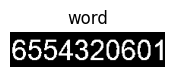

In [269]:
def erosion_image(binary_image):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    eroded_image = cv2.erode(binary_image, kernel, iterations=1)
    return eroded_image

def divide_word_in_text(text_img, histogram_word):
    word_group_img = []
    word_group_dummy = []
    for idx_histo, histo_word in enumerate(histogram_word):
        start_col = histo_word[0]
        end_col = histo_word[1]
        word_img = text_img[:, start_col-3:end_col+4]
        word_group_img.append(word_img)
        word_group_dummy.append(erosion_image(word_img))

    return word_group_img, word_group_dummy


    
line_text_word_images = []
line_text_word_dummy = []
for idx_line, line_text in enumerate(line_text_groups_images):
    #print("บรรทัดที่:", idx_line+1)
    word_in_text_group = []
    word_in_text_group_dummy = []
    for idx_text, text_img in enumerate(line_text):
        #print("   ข้อวามที่:", idx_text+1)
        histogram_word = histogram_projection(text_img, 8)
        word_img, word_dummy = divide_word_in_text(text_img, histogram_word)
        #print(len(word_img))

        word_in_text_group.append(word_img)
        word_in_text_group_dummy.append(word_dummy)
    line_text_word_images.append(word_in_text_group)
    line_text_word_dummy.append(word_in_text_group_dummy)


# การแบ่งมิติใน arry
print("จำนวนบรรทัด:", len(line_text_word_images)) 
print(" จำนวนข้อความในบรรทัด:", len(line_text_word_images[0])) 
print("   จำนวนคำในข้อความ:", len(line_text_word_images[0][0]))
print("     รูปคำ:", len(line_text_word_images[0][0][0])) 
plt.figure(figsize=(2,2))
plt.imshow(line_text_word_images[5][0][0], cmap="gray")
plt.title("word")
plt.axis("off")



        


## จับตัวอักษรในข้อความ

จำนวนบรรทัด: 6
 จำนวนข้อความในบรรทัด: 2
   จำนวนคำในข้อความ: 1
     ตัวอักษร: 7
       ตัวอักษร: 43


(-0.5, 19.5, 42.5, -0.5)

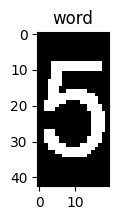

In [270]:
def divide_char_in_word(word_img, histogram_char):
    char_group_img = []
    for idx_histo, histo_char in enumerate(histogram_char):
        start_col = histo_char[0]
        end_col = histo_char[1]
        char_img = word_img[:, start_col-2:end_col+2]
        #print("    ", start_col, end_col)
        char_group_img.append(char_img)
        
    return char_group_img

def segment_image_horizontal(histogram, image):
    for start_col, end_col in histogram:
        char_img = image[:, start_col-2:end_col+5]
        return char_img
    
def segment_image_horizontal_V2(histogram, image):
    start_col, end_col = histogram[0], histogram[1]
    char_img = image[:, start_col-1:end_col+2]
    return char_img

def dilation_image(binary_image):
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    dilated_image = cv2.dilate(binary_image, kernel, iterations=2)
    return dilated_image

def histogram_projection_char(images, distance):
    # คำนวณ Histogram Projection
    horizontal_projection = np.sum(images, axis=0)  # รวมพิกเซลในแนวนอน
    threshold_value = 500  # เพิ่มค่าให้เหมาะกับความหนาของตัวอักษร
    column_indices = np.where(horizontal_projection > threshold_value)[0]

    # แยกช่วงตำแหน่งแต่ละบรรทัด
    columns = []
    start_idx = None

    for i in range(len(column_indices) - 1):
        if start_idx is None:
            start_idx = column_indices[i]
        if column_indices[i + 1] > column_indices[i] + distance:  # เจอช่องว่างระหว่างคอลัมน์
            end_idx = column_indices[i]
            columns.append((start_idx, end_idx))
            start_idx = None
    if start_idx is not None:
        columns.append((start_idx, column_indices[-1]))

    #plt.plot(horizontal_projection)
    #plt.title("Horizontal Projection")
    #plt.show()
    return columns


def contour_image(char_image):

    char_dilated_img = dilation_image(char_image)

    # หา Contours ในภาพ
    contours, _ = cv2.findContours(char_dilated_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # สร้างสำเนาภาพเพื่อวาดกรอบ
    line_with_boxes = cv2.cvtColor(char_dilated_img, cv2.COLOR_GRAY2BGR)

    for idx, contour in enumerate(contours):

        # คำนวณกรอบสี่เหลี่ยมรอบ Contour
        x, y, w, h = cv2.boundingRect(contour)

        # เพิ่มขนาดกรอบ 10%
        padding_x = int(w * 0.2)  # เพิ่ม 10% ของความกว้าง
        padding_y = int(h * 0.2)  # เพิ่ม 10% ของความสูง

        # ปรับขอบเขตของกรอบ
        x = max(0, x - padding_x)
        y = max(0, y - padding_y)
        w = min(line_img.shape[1] - x, w + 2 * padding_x)
        h = min(line_img.shape[0] - y, h + 2 * padding_y)

        # กำหนดเงื่อนไขเพื่อกรอง Noise หรือกล่องเล็กเกินไป

        if 2 < w < 100 and 10 < h < 100:  # ปรับค่าขนาดขั้นต่ำและสูงสุดตามต้องการ
            # ตัดภาพตัวอักษร
            char_img = char_image[y:y+h, x:x+w]

            # วาดกรอบสี่เหลี่ยมในภาพต้นฉบับ
            #cv2.rectangle(line_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 1)
            #cv2.imwrite(f"../data/output_images/output_characters/char_contours_{idx+1}.jpg", line_with_boxes)
            #cv2.imwrite(f"../data/output_images/output_characters/char_contours_crop_{idx+1}.jpg", char_img)

            return char_img


line_text_word_char_images = []
for idx_line, line in enumerate(line_text_word_images):
    #print("บรรทัดที่:", idx_line+1)

    text_word_char_group = []
    for idx_text, text in enumerate(line):
        #print("   ข้อวามที่:", idx_text+1)

        word_char_group = []
        for idx_word, word_img in enumerate(text):
            #print("     คำที่:", idx_word+1)
            #word_dummy = line_text_word_dummy[idx_line][idx_text][idx_word]
            histogram_char = histogram_projection_char(word_img, 2) #แบบปกติ
            #histogram_char = histogram_projection_char(word_dummy, 1) #แบบใช้ dummy
            

            #if(idx_line == 0 and idx_text == 0 and idx_word == 2):
            #    print(histogram_char)
            char_images = divide_char_in_word(word_img, histogram_char)

            char_group_images = [] #กลุ่มรูปภาพต่อตัวอักษร
            
            for char_im in char_images:
                char_contour = contour_image(char_im)
                char_group_images.append(char_contour)

                #plt.figure(figsize=(2,2))
                #plt.imshow(char_contour, cmap="gray")
                #plt.title("char")
                #plt.axis("on")
            word_char_group.append(char_group_images)
        text_word_char_group.append(word_char_group)
    line_text_word_char_images.append(text_word_char_group)



# การแบ่งมิติใน arry
print("จำนวนบรรทัด:", len(line_text_word_char_images)) 
print(" จำนวนข้อความในบรรทัด:", len(line_text_word_char_images[0])) 
print("   จำนวนคำในข้อความ:", len(line_text_word_char_images[0][0]))
print("     ตัวอักษร:", len(line_text_word_char_images[0][0][0])) 
print("       ตัวอักษร:", len(line_text_word_char_images[0][0][0][0])) 

plt.figure(figsize=(2,2))
plt.imshow(line_text_word_char_images[5][0][0][2], cmap="gray")
plt.title("word")
plt.axis("on")



            
            
            

## Predict images

In [264]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from PIL import Image, ImageOps
import math
import matplotlib.pyplot as plt

#letter_class = [chr(i) for i in range(ord('0'), ord('9') + 1)]
#letter_class = [chr(i) for i in range(ord('a'), ord('z') + 1)]

# ตัวอักษร 'a-z' และ 'A-Z'
lowercase = [chr(i) for i in range(ord('a'), ord('z') + 1)]
uppercase = [chr(i) for i in range(ord('A'), ord('Z') + 1)]

# สร้างลำดับ a, A, b, B, ...
letters_class = [val for pair in zip(lowercase, uppercase) for val in pair]


def resize_with_aspect_ratio_cv2(image, desired_size):
    """
    ปรับขนาดภาพให้คงสัดส่วนเดิม และเพิ่ม Padding ให้ได้ขนาด desired_size x desired_size
    """
    old_size = image.shape[:2]  # (height, width)
    ratio = float(desired_size) / max(old_size)  # อัตราส่วนการปรับขนาด
    new_size = tuple([int(x * ratio) for x in old_size])  # ขนาดใหม่ (height, width)

    # Resize ภาพให้คงสัดส่วนเดิม
    resized_image = cv2.resize(image, (new_size[1], new_size[0]), interpolation=cv2.INTER_AREA)

    # คำนวณ Padding
    delta_w = desired_size - new_size[1]  # Padding ด้านความกว้าง
    delta_h = desired_size - new_size[0]  # Padding ด้านความสูง
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    # เพิ่ม Padding รอบภาพ
    color = [0]  # สีดำสำหรับ Grayscale
    padded_image = cv2.copyMakeBorder(resized_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

    return padded_image

# โหลดโมเดลที่ฝึกไว้
#model_path = "../models/arabic_numerals_model.h5"
#model_path = "../models/eng_uppercase_model.h5"
#model_path = "../models/eng_lowercase_model.h5"
model_path = "../models/eng_upper_lowercase_model.h5"
model = load_model(model_path)

# กำหนดขนาด Input ของโมเดล
input_size = 32  # ขนาด 32x32

# เตรียมข้อมูลจาก text_char_group_images
processed_images = []

for char_img in text_char_group_images[0][0]:

    # เพิ่ม Padding และปรับขนาดภาพ
    padded_img = resize_with_aspect_ratio_cv2(char_img, input_size)
    
    # Normalization (เปลี่ยนค่าพิกเซลให้อยู่ในช่วง [0, 1])
    normalized_img = padded_img / 255.0

    # เพิ่มช่องทางสี (Channel) สำหรับโมเดลที่รองรับ Input แบบ (Height, Width, Channels)
    if len(normalized_img.shape) == 2:  # หากภาพเป็น Grayscale (2D)
        normalized_img = np.expand_dims(normalized_img, axis=-1)

    # เก็บภาพที่ประมวลผลแล้ว
    processed_images.append(normalized_img)

# แปลงเป็น NumPy Array
processed_images = np.array(processed_images)

# ทำนายผลลัพธ์
predictions = model.predict(processed_images)

# แปลงค่าความน่าจะเป็นเป็นคลาสที่คาดการณ์ได้ และ Confidence Score
predicted_classes = np.argmax(predictions, axis=1)
confidence_scores = np.max(predictions, axis=1)  # ดึงค่าสูงสุดจากแต่ละแถว (ความมั่นใจของคลาสที่ทำนาย)

# แสดงผลลัพธ์พร้อมภาพ
num_images = len(processed_images)
columns = 5  # จำนวนคอลัมน์ที่ต้องการ
rows = math.ceil(num_images / columns)  # คำนวณจำนวนแถวตามจำนวนภาพ

#plt.figure(figsize=(5, rows * 1))  # ปรับขนาดของกราฟให้รองรับจำนวนแถว
plt.figure(figsize=(columns * 2, rows * 2))  # ขนาดของกราฟสัมพันธ์กับจำนวนแถวและคอลัมน์
for idx, (padded_img, pred_label, confidence) in enumerate(zip(processed_images, predicted_classes, confidence_scores)):
    plt.subplot(rows, columns, idx + 1)  # ปรับ subplot ตามจำนวนแถวและคอลัมน์

    # แปลงภาพกลับเป็น 2D สำหรับการแสดงผล (ในกรณีที่เป็น (height, width, 1))
    if padded_img.shape[-1] == 1:
        padded_img = padded_img.squeeze()
    
    plt.imshow(padded_img, cmap='gray')  # แสดงภาพ Grayscale
    #plt.title(f"Pred: {pred_label + 1}", fontsize=10)  # แสดง Label ที่ทำนาย
    plt.title(f"Pred: {letters_class[pred_label]} ({confidence:.2%})", fontsize=10)  # แสดง Label และ % Confidence
    plt.axis('off')  # ปิดแกน

    print(f"Character {idx}: Predicted Label = {letters_class[pred_label]} ({confidence:.2%})")

plt.tight_layout()  # จัด Layout ให้ชิดกัน
plt.show()



NameError: name 'text_char_group_images' is not defined

## Predict images V2

In [243]:
model_path = "../models/eng_numerals_model.h5"
model = load_model(model_path)

In [244]:
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from PIL import Image, ImageOps
import math
import matplotlib.pyplot as plt

# ตัวเลข 0-9
numbers = [str(i) for i in range(10)]  # ['0', '1', ..., '9']

# ตัวอักษร a-z และ A-Z
lowercase = [chr(i) for i in range(ord('a'), ord('z') + 1)]  # ['a', 'b', ..., 'z']
uppercase = [chr(i) for i in range(ord('A'), ord('Z') + 1)]  # ['A', 'B', ..., 'Z']

# สร้างลำดับ a, A, b, B, ...
letters = [val for pair in zip(lowercase, uppercase) for val in pair]

# รวมตัวเลขและตัวอักษรทั้งหมด
letters_class = numbers + letters

#print(letters_class)
#letters_class = letters_class.extend(["0", "1", "2", "3", "4", "5", "6", "7"])

def resize_with_aspect_ratio_cv2(image, desired_size):
    """
    ปรับขนาดภาพให้คงสัดส่วนเดิม และเพิ่ม Padding ให้ได้ขนาด desired_size x desired_size
    """
    if image is None:
        raise ValueError("Input image is None. Please check the input data.")
    
    old_size = image.shape[:2]  # (height, width)
    ratio = float(desired_size) / max(old_size)  # อัตราส่วนการปรับขนาด
    new_size = tuple([int(x * ratio) for x in old_size])  # ขนาดใหม่ (height, width)

    # Resize ภาพให้คงสัดส่วนเดิม
    resized_image = cv2.resize(image, (new_size[1], new_size[0]), interpolation=cv2.INTER_AREA)

    # คำนวณ Padding
    delta_w = desired_size - new_size[1]  # Padding ด้านความกว้าง
    delta_h = desired_size - new_size[0]  # Padding ด้านความสูง
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    # เพิ่ม Padding รอบภาพ
    color = [0]  # สีดำสำหรับ Grayscale
    padded_image = cv2.copyMakeBorder(resized_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

    return padded_image

# กำหนดขนาด Input ของโมเดล
input_size = 32  # ขนาด 32x32

# เตรียมข้อมูลจาก text_char_group_images
processed_images = []

text_block = []
for line_text in text_char_group_images:
    for text in line_text:
        for idx, char_img in enumerate(text):
            if char_img is None:
                print(f"Character image {idx} is None.")
                continue  # ข้ามภาพนี้
            else:
                #plt.figure(figsize=(1,1))
                #plt.imshow(char_img, cmap="gray")

                # เพิ่ม Padding และปรับขนาดภาพ
                padded_img = resize_with_aspect_ratio_cv2(char_img, input_size)

                # Normalization (เปลี่ยนค่าพิกเซลให้อยู่ในช่วง [0, 1])
                normalized_img = padded_img / 255.0

                # เพิ่มช่องทางสี (Channel) สำหรับโมเดลที่รองรับ Input แบบ (Height, Width, Channels)
                if len(normalized_img.shape) == 2:  # หากภาพเป็น Grayscale (2D)
                    normalized_img = np.expand_dims(normalized_img, axis=-1)

                # เก็บภาพที่ประมวลผลแล้ว
                processed_images.append(normalized_img)
    
# แปลงเป็น NumPy Array
processed_images = np.array(processed_images)

print(len(processed_images))

# ทำนายผลลัพธ์
predictions = model.predict(processed_images)

# แปลงค่าความน่าจะเป็นเป็นคลาสที่คาดการณ์ได้ และ Confidence Score
predicted_classes = np.argmax(predictions, axis=1)
confidence_scores = np.max(predictions, axis=1)  # ดึงค่าสูงสุดจากแต่ละแถว (ความมั่นใจของคลาสที่ทำนาย)

for i, pred_class in enumerate(predicted_classes):
    predicted_letter = letters_class[pred_class]  # แปลงคลาสเป็นตัวอักษร
    confidence = confidence_scores[i]  # คะแนนความมั่นใจ
    text_block.append((predicted_letter, confidence))  # เก็บผลลัพธ์

# แสดงผลลัพธ์
for letter, confidence in text_block:
    print(f"Predicted Letter: {letter}, Confidence: {confidence:.2f}")
    #predicted_text = ''.join([letter for letter, confidence in text_block])
    #print(f"Predicted Text: {predicted_text}")

full_text = []  # เก็บข้อความทั้งหมด

for line_idx, line_text in enumerate(text_char_group_images):
    line_string = ""  # เก็บข้อความในแต่ละบรรทัด
    for char_idx, char_img in enumerate(line_text):
        predicted_letter = letters_class[predicted_classes[char_idx]]
        line_string += predicted_letter  # ต่ออักษรในบรรทัดนี้
    full_text.append(line_string)  # เก็บข้อความของบรรทัดนี้

# รวมทุกบรรทัดเข้าด้วยกัน (แยกด้วย \n)
final_text = '\n'.join(full_text)

# แสดงผลลัพธ์
print("Predicted Text by Line:")
print(final_text)




# แสดงผลลัพธ์พร้อมภาพ
num_images = len(processed_images)
columns = 5  # จำนวนคอลัมน์ที่ต้องการ
rows = math.ceil(num_images / columns)  # คำนวณจำนวนแถวตามจำนวนภาพ



'''
#plt.figure(figsize=(5, rows * 1))  # ปรับขนาดของกราฟให้รองรับจำนวนแถว
plt.figure(figsize=(columns * 3, rows * 3))  # ขนาดของกราฟสัมพันธ์กับจำนวนแถวและคอลัมน์
for idx, (padded_img, pred_label, confidence) in enumerate(zip(processed_images, predicted_classes, confidence_scores)):
    plt.subplot(rows, columns, idx + 1)  # ปรับ subplot ตามจำนวนแถวและคอลัมน์

    # แปลงภาพกลับเป็น 2D สำหรับการแสดงผล (ในกรณีที่เป็น (height, width, 1))
    if padded_img.shape[-1] == 1:
        padded_img = padded_img.squeeze()
    
    plt.imshow(padded_img, cmap='gray')  # แสดงภาพ Grayscale
    #plt.title(f"Pred: {pred_label + 1}", fontsize=10)  # แสดง Label ที่ทำนาย
    plt.title(f"Pred: {letters_class[pred_label]} ({confidence:.2%})", fontsize=10)  # แสดง Label และ % Confidence
    plt.axis('off')  # ปิดแกน

    print(f"Character {idx}: Predicted Label = {letters_class[pred_label]} ({confidence:.2%})")

plt.tight_layout()  # จัด Layout ให้ชิดกัน
plt.show()
'''

NameError: name 'text_char_group_images' is not defined

## Predict images V3

In [273]:
from tensorflow.keras.models import load_model
model_path = "../models/eng_numerals_model.h5"
model = load_model(model_path)

In [274]:
import enchant
from Levenshtein import distance

# สร้าง Dictionary ภาษาอังกฤษ
d = enchant.Dict("en_US")

custom_words = ["Phrae", "phrae"]
for word in custom_words:
    d.add(word)

# ฟังก์ชันตรวจสอบคำผิดและแก้ไขตามเงื่อนไข
def correct_word(word, max_distance=3):
    if not word:  # ตรวจสอบว่าคำเป็นค่าว่าง
        return word  # ถ้าเป็นค่าว่าง ให้ return ค่าว่างทันที
    if d.check(word):
        return word  # หากคำถูกต้องแล้ว
    suggestions = d.suggest(word)
    for suggestion in suggestions:
        if distance(word, suggestion) <= max_distance:  # เช็คระยะทาง Levenshtein
            return suggestion
    return word  # หากไม่มีคำแนะนำที่อยู่ในระยะที่กำหนด

#print(correct_word("Mobiie"))

def Rule_Based_Post_Processing(word):

    # ยกเว้นตัวแรก แล้วเปลี่ยน 'I' เป็น 'l'
    if not word:
        return word
    
    first_char = word[0]  # ตัวอักษรตัวแรก
    rest = word[1:]  # ข้อความที่เหลือหลังตัวแรก
    modified_rest = rest.replace("I", "l")  # เปลี่ยน 'I' เป็น 'l' ในส่วนที่เหลือ
    word_result = first_char + modified_rest  # รวมกลับ


    # กำหนดค่าเริ่มต้น
    result = word_result

    if len(word_result) < 2:  # ข้อความสั้นเกินไปที่จะตรวจตัวแรกและตัวสุดท้าย
        return word_result
    
    # ตรวจสอบว่าตัวแรกและตัวสุดท้ายเป็นตัวเลข
    if len(word_result) >= 2 and word_result[0].isdigit() and word_result[-1].isdigit():
        # แปลง 'o' และ 'O' เป็น '0' ในข้อความ
        result = word_result[0] + word_result[1:-1].replace("o", "0").replace("O", "0") + word_result[-1]

    # เพิ่มเงื่อนไขใหม่: หากไม่ใช่ตัวเลขและความยาว >= 6 ให้เรียกใช้ correct_word
    #if not word.isdigit() and len(word) >= 6:
    #   result = correct_word(result)
    
    #return result.replace(" ", "")
    return result


print(Rule_Based_Post_Processing("Cenificate"))



Cenificate


In [275]:
import cv2
import numpy as np
from PIL import Image, ImageOps
import math
import matplotlib.pyplot as plt

# ตัวเลข 0-9
numbers = [str(i) for i in range(10)]  # ['0', '1', ..., '9']

# ตัวอักษร a-z และ A-Z
lowercase = [chr(i) for i in range(ord('a'), ord('z') + 1)]  # ['a', 'b', ..., 'z']
uppercase = [chr(i) for i in range(ord('A'), ord('Z') + 1)]  # ['A', 'B', ..., 'Z']

# สร้างลำดับ a, A, b, B, ...
letters = [val for pair in zip(lowercase, uppercase) for val in pair]

# รวมตัวเลขและตัวอักษรทั้งหมด
letters_class = numbers + letters

def resize_with_aspect_ratio_cv2(image, desired_size):
    """
    ปรับขนาดภาพให้คงสัดส่วนเดิม และเพิ่ม Padding ให้ได้ขนาด desired_size x desired_size
    """
    if image is None:
        raise ValueError("Input image is None. Please check the input data.")
    
    old_size = image.shape[:2]  # (height, width)
    ratio = float(desired_size) / max(old_size)  # อัตราส่วนการปรับขนาด
    new_size = tuple([int(x * ratio) for x in old_size])  # ขนาดใหม่ (height, width)

    # Resize ภาพให้คงสัดส่วนเดิม
    resized_image = cv2.resize(image, (new_size[1], new_size[0]), interpolation=cv2.INTER_AREA)

    # คำนวณ Padding
    delta_w = desired_size - new_size[1]  # Padding ด้านความกว้าง
    delta_h = desired_size - new_size[0]  # Padding ด้านความสูง
    top, bottom = delta_h // 2, delta_h - (delta_h // 2)
    left, right = delta_w // 2, delta_w - (delta_w // 2)

    # เพิ่ม Padding รอบภาพ
    color = [0]  # สีดำสำหรับ Grayscale
    padded_image = cv2.copyMakeBorder(resized_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

    return padded_image

# กำหนดขนาด Input ของโมเดล
input_size = 32  # ขนาด 32x32

# เตรียมข้อมูลจาก text_char_group_images
processed_images = []

text_block = []

for idx_line, line_text in enumerate(line_text_word_char_images):
    #print("บรรทัดที่:", idx_line+1)

    for idx_text, text in enumerate(line_text):
        #print("   ข้อความที่:", idx_text+1)
        text_result = ""  # ใช้เก็บข้อความของบรรทัดนี้
        for idx_word, word in enumerate(text):
            #print("     คำที่:", idx_word+1)
            word_result = ""
            for idx_char, char in enumerate(word):
                #print("     คำที่:", idx_word+1)
                if char is None:
                    print(f"Character image {idx} is None.")
                    continue  # ข้ามภาพนี้
                else:
                    padded_img = resize_with_aspect_ratio_cv2(char, input_size)
                    normalized_img = padded_img / 255.0

                    if len(normalized_img.shape) == 2:  # หากภาพเป็น Grayscale (2D)
                        normalized_img = np.expand_dims(normalized_img, axis=-1)

                    processed_image = np.expand_dims(normalized_img, axis=0)  # เพิ่ม Batch Dimension
                    prediction = model.predict(processed_image)
                    predicted_class = np.argmax(prediction)
                    confidence_score = np.max(prediction)

                    # แปลงคลาสเป็นตัวอักษร
                    predicted_letter = letters_class[predicted_class]

                    # เพิ่มตัวอักษรไปยังข้อความของบรรทัดนี้
                    word_result += predicted_letter

                    #plt.figure(figsize=(2,2))
                    #plt.imshow(char, cmap="gray")
                    #plt.title("char")
                    #plt.axis("on")
            #correct_word_result = correct_word(word_result)
            #correct_word_result += " "
            #text_result += correct_word_result

            word_post_processing = Rule_Based_Post_Processing(word_result)
            word_post_processing += " "
            text_result += word_post_processing
            # เพิ่มข้อความของบรรทัดนี้ไปยังผลลัพธ์ทั้งหมด
        text_block.append(text_result)

# แสดงผลลัพธ์ข้อความ
for idx_text, text in enumerate(text_block):
    print(f"text {idx_text + 1}: {text.title()}")
    

1/1 [==============================] - 0s 16ms/step
text 1: Opaspun 
text 2: Klinchuemit 
text 3: 6S5432060391 
text 4: Putipong 
text 5: Leekeawsai 
text 6: 6S5432060284 
text 7: Nutaput 
text 8: Jamankithumkorn 
text 9: 6S54320601 1 O 
